---
title: "Midterm Project"
author: "Alyssa Horn"
toc: true
number-sections: true
self-contained: true
highlight-style: pygments
format: 
  html: 
    code-fold: true
    html-math-method: katex
    self-contained: true
  pdf: 
    geometry: 
      - top=30mm
      - left=20mm
---


## Notes
* Cleaning
    * missing zipcode not as big an issue for this dataset
* Exploration
    * Use leaflet like the homework but using different symbols
    * response time - someone needs to look at it and close it - from created date to closed date
    * 2 descriptors: SF and CB. Might want to do the comparison by borough. These are right skewed data. Might need to use a different scale?
    * hypothesis tests
      * Difference in borough: 2-way ANOVA, justify whatever test used
    * Binary variable: should be similar to what we have in iii
* Modeling the count
    * i. should get 174
    * Use zipcode as key to merge
    * lag: maybe if there is more rain - then there are more complaints the next day?
    * Neg binomial is def better because mean and variance do not need to be the same
    * creating count code is on class notes along with the lag

# Data Cleaning

## Import the data, rename the columns with our preferred styles.

In [1]:
import pandas as pd

# Load data
file_path = "nycflood2024.csv" 
df = pd.read_csv(file_path)

# Rename columns
df.columns = df.columns.str.lower().str.replace(" ", "_")

df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,63574884,12/31/2024 11:05:00 PM,01/01/2025 05:55:00 AM,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,11434.0,177-37 135 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.675681,-73.762969,"(40.67568056757403, -73.76296916912234)"
1,63580185,12/31/2024 11:02:00 PM,01/01/2025 10:30:00 AM,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,11219.0,4102 14 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.638098,-73.985346,"(40.63809797146557, -73.98534616586583)"
2,63573084,12/31/2024 11:02:00 PM,01/01/2025 06:20:00 AM,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,11361.0,35-34 CORPORAL KENNEDY STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.767455,-73.778079,"(40.767454543462755, -73.77807940403599)"
3,63581809,12/31/2024 10:35:00 PM,01/01/2025 11:20:00 AM,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,11219.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.636495,-73.987000,"(40.636495214873584, -73.98700030399515)"
4,63578460,12/31/2024 10:11:00 PM,01/02/2025 12:45:00 PM,DEP,Department of Environmental Protection,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),NaN,10305.0,225 HYLAN BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.612337,-74.069589,"(40.612337196854604, -74.06958876337421)"


## Summarize the missing information. Are there variables that are close to completely missing?

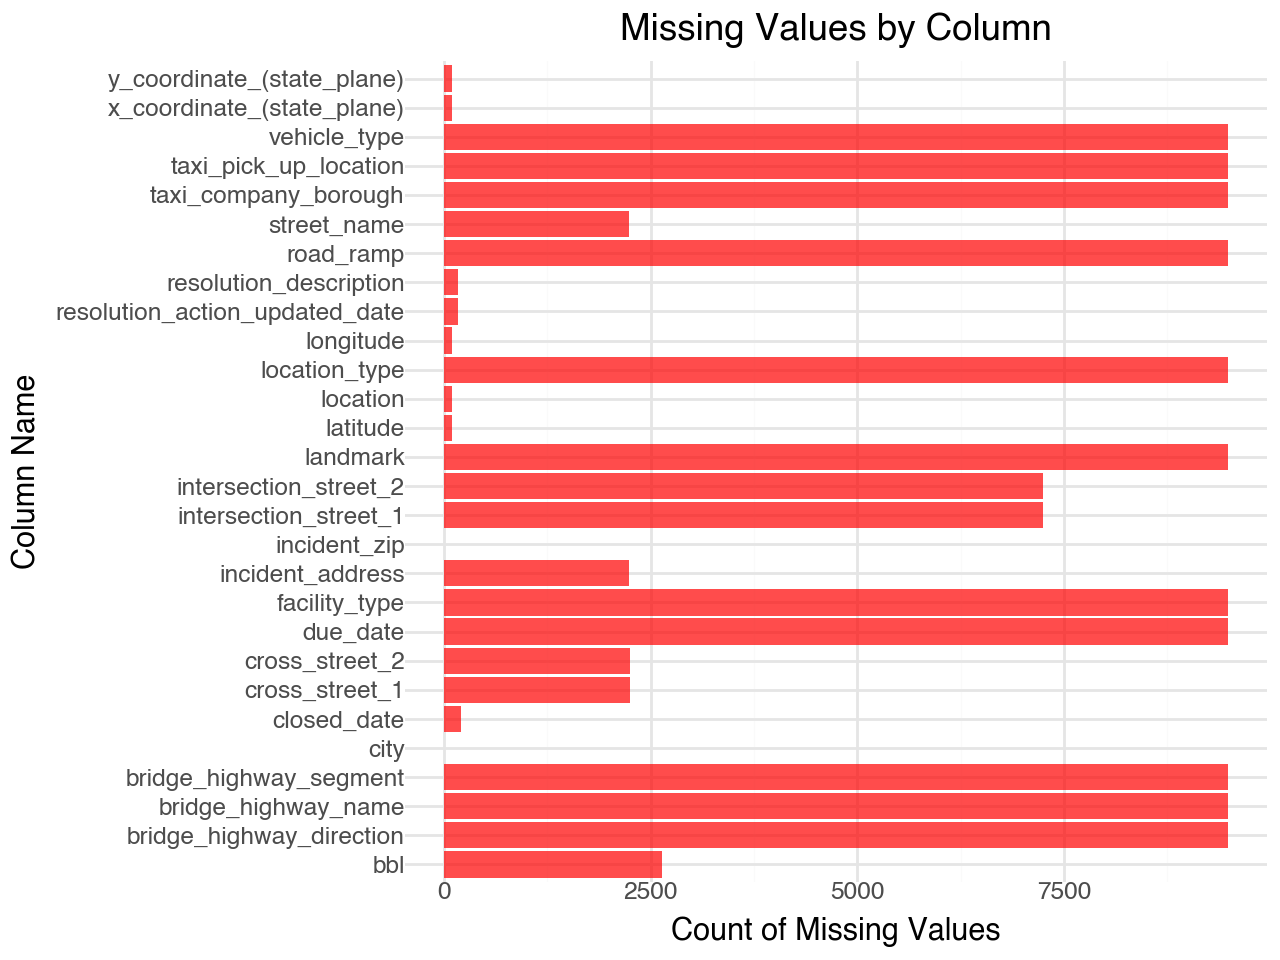

In [2]:
# Check for missing values
missing_summary = df.isnull().sum()

from plotnine import ggplot, aes, geom_bar, theme_minimal, coord_flip, labs, geom_boxplot
import pandas as pd

# Check missing values
missing_summary = df.isnull().sum().reset_index()
missing_summary.columns = ["Column", "Missing_Count"]
missing_summary = missing_summary[missing_summary["Missing_Count"] > 0]
missing_summary = missing_summary.sort_values(by="Missing_Count", ascending=False)

# Create a bar plot
missing_plot = (
    ggplot(missing_summary, aes(x="Column", y="Missing_Count"))
    + geom_bar(stat="identity", fill="red", alpha=0.7)
    + coord_flip()  # Flip for better readability
    + theme_minimal()
    + labs(title="Missing Values by Column", x="Column Name", y="Count of Missing Values")
)

missing_plot

In [3]:
missing_summary = df.isnull().sum()

# Find columns with missing values over 80%
high_missing = missing_summary[missing_summary / len(df) > 0.8]

high_missing

location_type               9483
landmark                    9483
facility_type               9483
due_date                    9483
vehicle_type                9483
taxi_company_borough        9483
taxi_pick_up_location       9483
bridge_highway_name         9483
bridge_highway_direction    9483
road_ramp                   9483
bridge_highway_segment      9483
dtype: int64

## Are there redundant information in the data? Try storing the data using the Arrow format and comment on the efficiency gain.

In [4]:
# Drop redundant location column since we have longitude and latitude
df = df.drop(columns=['location'])

# Drop redundant location column since we address
df = df.drop(columns=['street_name'])

# Drop redundant location column since we have agency
df = df.drop(columns=['agency_name'])

# Drop redundant location column since we have borough
df = df.drop(columns=['park_borough'])

df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'complaint_type',
       'descriptor', 'location_type', 'incident_zip', 'incident_address',
       'cross_street_1', 'cross_street_2', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'landmark',
       'facility_type', 'status', 'due_date', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_(state_plane)', 'y_coordinate_(state_plane)',
       'open_data_channel_type', 'park_facility_name', 'vehicle_type',
       'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment',
       'latitude', 'longitude'],
      dtype='object')

In [5]:
import pyarrow.feather as feather
import os

# Save dataset in Feather format
feather_file = "nycflood2024.feather"
df.to_feather(feather_file)

# Compare file sizes
csv_size = os.path.getsize(file_path)
feather_size = os.path.getsize(feather_file)
compression_gain = (1 - feather_size / csv_size) * 100

print(f"CSV file size: {csv_size / 1024:.2f} KB")
print(f"Feather file size: {feather_size / 1024:.2f} KB")
print(f"Compression Efficiency Gain: {compression_gain:.2f}%")

CSV file size: 5962.98 KB
Feather file size: 1465.19 KB
Compression Efficiency Gain: 75.43%


## Are there invalid NYC zipcode or borough? Can some of the missing values be filled? Fill them if yes.

In [6]:
import numpy as np
from geopy.geocoders import Nominatim
import time

# Check co-occurring missing values
missing_cooccur = df[['incident_zip', 'borough']].isnull().all(axis=1).sum()
total_missing_zip_code = df['incident_zip'].isnull().sum()
total_missing_borough = df['borough'].isnull().sum()

print("Missing Zip & Borough Together:", missing_cooccur)
print("Total Missing Zip Codes:", total_missing_zip_code)
print("Total Missing Boroughs:", total_missing_borough)

Missing Zip & Borough Together: 0
Total Missing Zip Codes: 4
Total Missing Boroughs: 0


In [7]:
# Filter rows where zip_code (incident_zip) is missing but borough is present
missing_zip_present_borough = df[df['incident_zip'].isna() & df['borough'].notna()][['incident_zip', 'borough']]

# Display the first few rows
missing_zip_present_borough


,incident_zip,borough
58,NaN,QUEENS
189,NaN,MANHATTAN
1903,NaN,MANHATTAN
6333,NaN,QUEENS


Since these four columns that have missing zip code also have missing longitude and latitude, they cannot be filled using geocoders. Borough is not missing, however, there are several zip codes pertaining to each borough so we are unable to tell which zip code the incident belongs to. I filled the zip code with the most common zip from incidents with the same borough:

In [8]:
# Most common Zip in each borough
most_common_zip_by_borough = df.groupby('borough')['incident_zip'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

# Fill missing with most common borough zip
missing_zip = df['incident_zip'].isna() & df['borough'].notna()
df.loc[missing_zip, 'incident_zip'] = df.loc[missing_zip, 'borough'].map(most_common_zip_by_borough)

# Check how many still missing
missing_after = df['incident_zip'].isna().sum()
print("Missing zip codes AFTER fill:", missing_after)


Missing zip codes AFTER fill: 0


## Are there date errors? Examples are earlier closed_date than created_date; closed_date and created_date matching to the second; dates exactly at midnight or noon to the second.

In [9]:
df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')
df['closed_date'] = pd.to_datetime(df['closed_date'], errors='coerce')

# Check if it worked
print(df[['created_date', 'closed_date']].head(10))

/var/folders/h3/b6hmdmrj4_s50l70g177sf680000gn/T/ipykernel_38646/842059704.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


         created_date         closed_date
0 2024-12-31 23:05:00 2025-01-01 05:55:00
1 2024-12-31 23:02:00 2025-01-01 10:30:00
2 2024-12-31 23:02:00 2025-01-01 06:20:00
3 2024-12-31 22:35:00 2025-01-01 11:20:00
4 2024-12-31 22:11:00 2025-01-02 12:45:00
5 2024-12-31 21:59:00 2025-01-01 09:45:00
6 2024-12-31 19:26:00 2025-01-01 08:50:00
7 2024-12-31 16:32:00 2025-01-01 09:10:00
8 2024-12-31 14:08:00 2025-01-01 09:30:00
9 2024-12-31 14:02:00 2025-01-01 08:15:00


In [10]:
df.dtypes[['created_date', 'closed_date']]

created_date    datetime64[ns]
closed_date     datetime64[ns]
dtype: object

In [11]:
# closed_date is earlier than created_date
date_errors = df[df['closed_date'] < df['created_date']]
print(f"Rows where closed_date is earlier than created_date: {len(date_errors)}")

# closed_date and created_date match exactly
same_second = df[df['created_date'] == df['closed_date']]
print(f"Rows where created_date == closed_date: {len(same_second)}")

# created_date is exactly at midnight or noon
midnight_noon = df[df['created_date'].dt.strftime("%H:%M:%S").isin(["00:00:00", "12:00:00"])]
print(f"Rows with created_date exactly at midnight or noon: {len(midnight_noon)}")

# missing created_date or closed_date
missing_created = df['created_date'].isna().sum()
missing_closed = df['closed_date'].isna().sum()
print(f"Missing created_date: {missing_created}")
print(f"Missing closed_date: {missing_closed}")

# complaints open for an unusually long time (over a year)
long_open_cases = df[(df['closed_date'].notna()) & ((df['closed_date'] - df['created_date']).dt.days > 365)]
print(f"Cases open for more than a year: {len(long_open_cases)}")

# cases where dates are too old or in future
too_old = df[df['created_date'] < pd.Timestamp("2010-01-01")]
too_future = df[df['closed_date'] > pd.Timestamp.today()]
print(f"Rows with created_date before 2010: {len(too_old)}")
print(f"Rows with closed_date in the future: {len(too_future)}")

Rows where closed_date is earlier than created_date: 1
Rows where created_date == closed_date: 160
Rows with created_date exactly at midnight or noon: 0
Missing created_date: 0
Missing closed_date: 208
Cases open for more than a year: 0
Rows with created_date before 2010: 0
Rows with closed_date in the future: 0


## Summarize your suggestions to the data curator in several bullet points.

* Remove redundant columns.
    * Some columns like location, stree_name, park_borough, and agency_name are redundant of other columns and do not need to be included in the dataset. 
* Address missing or incorrect dates.
    * Some rows include closed dates eariler than created dates.
    * There are rows that have equal close and open dates and times - indicating an entry error/default.
    * There are rows that have missing closed dates, meaning some may have been left open or not updated in teh database.
* Store data more efficiently.
    * The curator should consider storing the data in feather format for better performance and reduce the size of the file. 

# Exploratory Analysis

## Visualize the locations of complaints on a NYC map, with different symbols for different descriptors.

In [12]:
# Standardize the descriptor column
df['descriptor'] = (
    df['descriptor']
    .astype(str)  # Ensure it's a string
    .str.strip()  # Remove leading/trailing spaces
    .str.lower()  # Convert to lowercase
    .str.replace(r"\s+", "_", regex=True)  # Replace spaces with underscores
)

df['descriptor'].unique()


array(['street_flooding_(sj)',
       'catch_basin_clogged/flooding_(use_comments)_(sc)'], dtype=object)

In [13]:
import folium
from folium.plugins import MarkerCluster

# Create map
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Different markers
descriptor_icons = {
    'street_flooding_(sj)': "tint",
    'catch_basin_clogged/flooding_(use_comments)_(sc)': "exclamation-triangle",
}

# Default icon
default_icon = "cloud"

df['descriptor'] = df['descriptor'].astype(str).str.strip().str.lower()

# Create marker Cluster
marker_cluster = MarkerCluster().add_to(nyc_map)

# Plot locations
for _, row in df.dropna(subset=['latitude', 'longitude']).iterrows():
    descriptor = row['descriptor']
    icon = descriptor_icons.get(descriptor, default_icon)
    
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['descriptor']} - {row['borough']}",
        icon=folium.Icon(icon=icon, prefix="fa")
    ).add_to(marker_cluster)

nyc_map.save("nyc_complaints_map.html")

[View NYC Complaints Map](nyc_complaints_map.html)

## Create a variable response_time, which is the duration from created_date to closed_date.

In [14]:
df[['created_date', 'closed_date']].astype(str).head(10)

,created_date,closed_date
0,2024-12-31 23:05:00,2025-01-01 05:55:00
1,2024-12-31 23:02:00,2025-01-01 10:30:00
2,2024-12-31 23:02:00,2025-01-01 06:20:00
3,2024-12-31 22:35:00,2025-01-01 11:20:00
4,2024-12-31 22:11:00,2025-01-02 12:45:00
5,2024-12-31 21:59:00,2025-01-01 09:45:00
6,2024-12-31 19:26:00,2025-01-01 08:50:00
7,2024-12-31 16:32:00,2025-01-01 09:10:00
8,2024-12-31 14:08:00,2025-01-01 09:30:00
9,2024-12-31 14:02:00,2025-01-01 08:15:00


In [15]:
# Response time in days
df['response_time'] = (df['closed_date'] - df['created_date']).dt.total_seconds() / (60*60*24)

# Remove negative
df = df[df['response_time'] >= 0]

# Summary statistics
df['response_time'].describe()

count    9274.000000
mean        2.326430
std         6.199547
min         0.000000
25%         0.230729
50%         0.917361
75%         2.752778
max       281.846528
Name: response_time, dtype: float64

In [16]:
df['response_time'].head()

0    0.284722
1    0.477778
2    0.304167
3    0.531250
4    1.606944
Name: response_time, dtype: float64

## Visualize the comparison of response time by complaint descriptor and borough. The original may not be the best given the long tail or outlers.

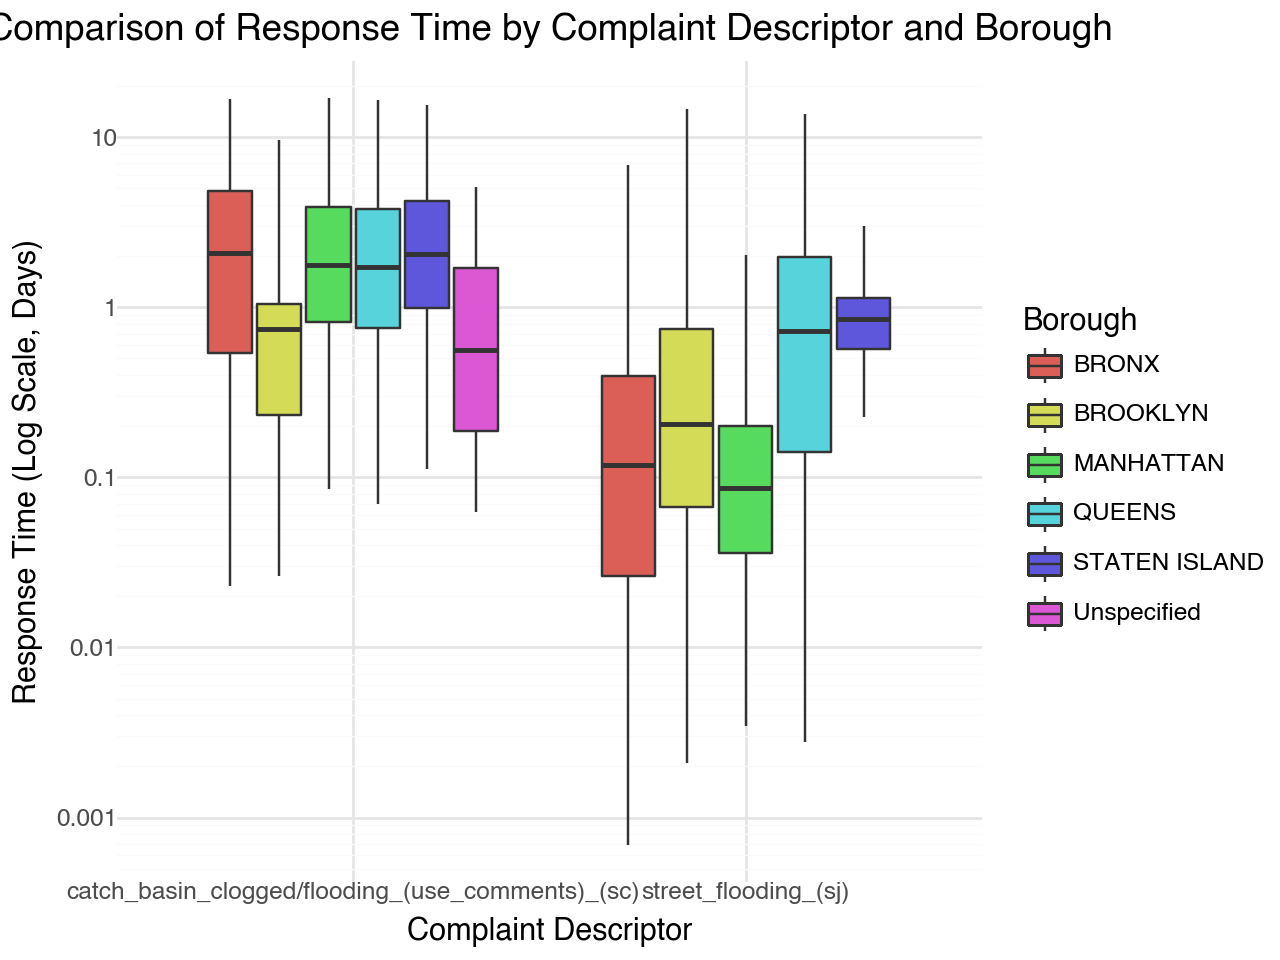

In [17]:
from plotnine import scale_y_log10

# Remove NaN values and zero values
df_filtered = df[df['response_time'].notna() & (df['response_time'] > 0)]

# Remove extreme outliers
response_time_cap = np.percentile(df_filtered['response_time'], 99)
df_filtered = df_filtered[df_filtered['response_time'] <= response_time_cap]

# Create the boxplot
response_plot = (
    ggplot(df_filtered, aes(x='descriptor', y='response_time', fill='borough')) +
    geom_boxplot(outlier_shape='') +
    scale_y_log10() +  # Use log scale to handle long tail
    theme_minimal() +
    labs(
        title="Comparison of Response Time by Complaint Descriptor and Borough",
        x="Complaint Descriptor",
        y="Response Time (Log Scale, Days)",
        fill="Borough"
    )
)

response_plot

## Is there significant difference in response time between SF and CB complaints? Across different boroughs? Does the difference between SF and CB depend on borough? State your hypothesis, justify your test, and summarize your results in plain English.

In [18]:
# Extract SF and CB complaints
sf_complaints = df[df['descriptor'].str.contains('street_flooding', case=False, na=False)]
cb_complaints = df[df['descriptor'].str.contains('catch_basin', case=False, na=False)]
sf_complaints.head()

,unique_key,created_date,closed_date,agency,complaint_type,descriptor,location_type,incident_zip,incident_address,cross_street_1,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,response_time
0,63574884,2024-12-31 23:05:00,2025-01-01 05:55:00,DEP,Sewer,street_flooding_(sj),NaN,11434.0,177-37 135 AVENUE,FARMERS BLVD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.675681,-73.762969,0.284722
1,63580185,2024-12-31 23:02:00,2025-01-01 10:30:00,DEP,Sewer,street_flooding_(sj),NaN,11219.0,4102 14 AVENUE,41 ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.638098,-73.985346,0.477778
2,63573084,2024-12-31 23:02:00,2025-01-01 06:20:00,DEP,Sewer,street_flooding_(sj),NaN,11361.0,35-34 CORPORAL KENNEDY STREET,35 AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.767455,-73.778079,0.304167
3,63581809,2024-12-31 22:35:00,2025-01-01 11:20:00,DEP,Sewer,street_flooding_(sj),NaN,11219.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.636495,-73.987000,0.531250
7,63578409,2024-12-31 16:32:00,2025-01-01 09:10:00,DEP,Sewer,street_flooding_(sj),NaN,11377.0,41-40 72 STREET,41 AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.743976,-73.893316,0.693056


### Check if response_times is normally distributed

In [19]:
from scipy.stats import shapiro

# Drop NaN values in response_time
response_times = df['response_time'].dropna()

# Shapiro-Wilk test (best for small samples, <5000 observations)
shapiro_p = shapiro(response_times.sample(min(len(response_times), 5000)))[1] if len(response_times) > 3 else 1

# Print results
print(f"Shapiro-Wilk Test p-value: {shapiro_p:.5f}")

# Interpretation: If p-value < 0.05, reject normality assumption
if shapiro_p < 0.05:
    print("Conclusion: Response times are NOT normally distributed (p < 0.05).")
else:
    print("Conclusion: Response times appear to be normally distributed (p >= 0.05).")


Shapiro-Wilk Test p-value: 0.00000
Conclusion: Response times are NOT normally distributed (p < 0.05).


### Use Wilcoxon rank-sum test for two independent samples
This test is appropriate because response times are not normally distributed. SF and CB are two independent samples. 

H: (Null Hypothesis): There is no significant difference in response times between Street Flooding (SF) and Catch Basin (CB) complaints.

Ho: (Alternative Hypothesis): There is a significant difference in response times between SF and CB complaints.

In [20]:
from scipy.stats import ranksums

# Drop Nas
sf_times = sf_complaints['response_time'].dropna()
cb_times = cb_complaints['response_time'].dropna()

# Perform Wilcoxon Rank-Sum test
stat, p_value = ranksums(sf_times, cb_times)

# Print results
print(f"Test Used: Wilcoxon Rank-Sum Test (ranksums)")
print(f"P-value: {p_value:.5f}")
print(f"Significant Difference? {'Yes' if p_value < 0.05 else 'No'}")

Test Used: Wilcoxon Rank-Sum Test (ranksums)
P-value: 0.00000
Significant Difference? Yes


Since the p-value is less than 0.05, we reject the null hypothesis. This means that response times for SF and CB complaints are significantly different. This means the type of complaint has a significant impact on how long it takes for a request to be resolved. 

### Use Kruskal-Wallis H-test to test across different boroughs
This test is appropriate because response times are not normally distributed. SF and CB are independent samples. Use Kruskal-Wallis to compare locations.

Ho: There is no significant difference in response times across different boroughs.

H1: There is a significant difference in response times between at least one pair of boroughs.

In [21]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis H-test across different boroughs
borough_groups = [df[df['borough'] == borough]['response_time'].dropna() for borough in df['borough'].dropna().unique() if len(df[df['borough'] == borough]['response_time'].dropna()) > 3]

# Only run Kruskal-Wallis if multiple boroughs have sufficient data
if len(borough_groups) > 1:
    stat_kruskal, p_value_kruskal = kruskal(*borough_groups)
    print(f"\nTest Used: Kruskal-Wallis H-test Across Boroughs")
    print(f"P-value: {p_value_kruskal:.5f}")
    print(f"Significant Difference? {'Yes' if p_value_kruskal < 0.05 else 'No'}")
else:
    print("\nNot enough valid boroughs to perform Kruskal-Wallis test.")


Test Used: Kruskal-Wallis H-test Across Boroughs
P-value: 0.00000
Significant Difference? Yes


Since the p-value is less than 0.05, we reject the null hypothesis. This means that response times differ significantly across boroughs. At least one borough has a significantly different response time compared to the others. This suggests that the borough where a complaint is made affects how long it takes to resolve.

### Use Wilcoxon rank-sum test to test difference between SF and CB for each borough
This test is appropriate because response times are not normally distributed. SF and CB are two independent samples.

Ho: There is no significant difference in response times between SF and CB complaints within each borough.

H1: There is a significant difference in response times between SF and CB complaints within each borough.

In [22]:
# Initialize dictionary to store borough-wise results
borough_results = {}

# Loop through each borough and compare SF vs. CB response times
for borough in df['borough'].dropna().unique():
    sf_b_times = df[(df['borough'] == borough) & df['descriptor'].str.contains('street_flooding', case=False, na=False)]['response_time'].dropna()
    cb_b_times = df[(df['borough'] == borough) & df['descriptor'].str.contains('catch_basin', case=False, na=False)]['response_time'].dropna()

    # Ensure there are enough samples for a meaningful test
    if len(sf_b_times) > 3 and len(cb_b_times) > 3:
        stat, p_borough = ranksums(sf_b_times, cb_b_times)
        borough_results[borough] = {'Test': "Wilcoxon Rank-Sum Test", 'P-value': p_borough}

# Display borough-wise results
print("\nBorough-wise Comparison of Response Times (SF vs. CB):")
for borough, result in borough_results.items():
    print(f"{borough}: {result['Test']} - P-value: {result['P-value']:.5f} - Significant? {'Yes' if result['P-value'] < 0.05 else 'No'}")


Borough-wise Comparison of Response Times (SF vs. CB):
QUEENS: Wilcoxon Rank-Sum Test - P-value: 0.00000 - Significant? Yes
BROOKLYN: Wilcoxon Rank-Sum Test - P-value: 0.00000 - Significant? Yes
STATEN ISLAND: Wilcoxon Rank-Sum Test - P-value: 0.00000 - Significant? Yes
MANHATTAN: Wilcoxon Rank-Sum Test - P-value: 0.00000 - Significant? Yes
BRONX: Wilcoxon Rank-Sum Test - P-value: 0.00000 - Significant? Yes


Since all p-values are less than 0.05, we reject the null hypothesis for every borough. This means that response times for Street Flooding and Catch Basin complaints differ significantly across all boroughs. The type of complaint descriptor has a significant impact on response time in every borough.

#### Histrogram of response times for each borough

/Users/alyssahorn/5-nyc-data-exploration-alyssahorn/venv/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 50 rows containing non-finite values.
/Users/alyssahorn/5-nyc-data-exploration-alyssahorn/venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 14 rows containing missing values.


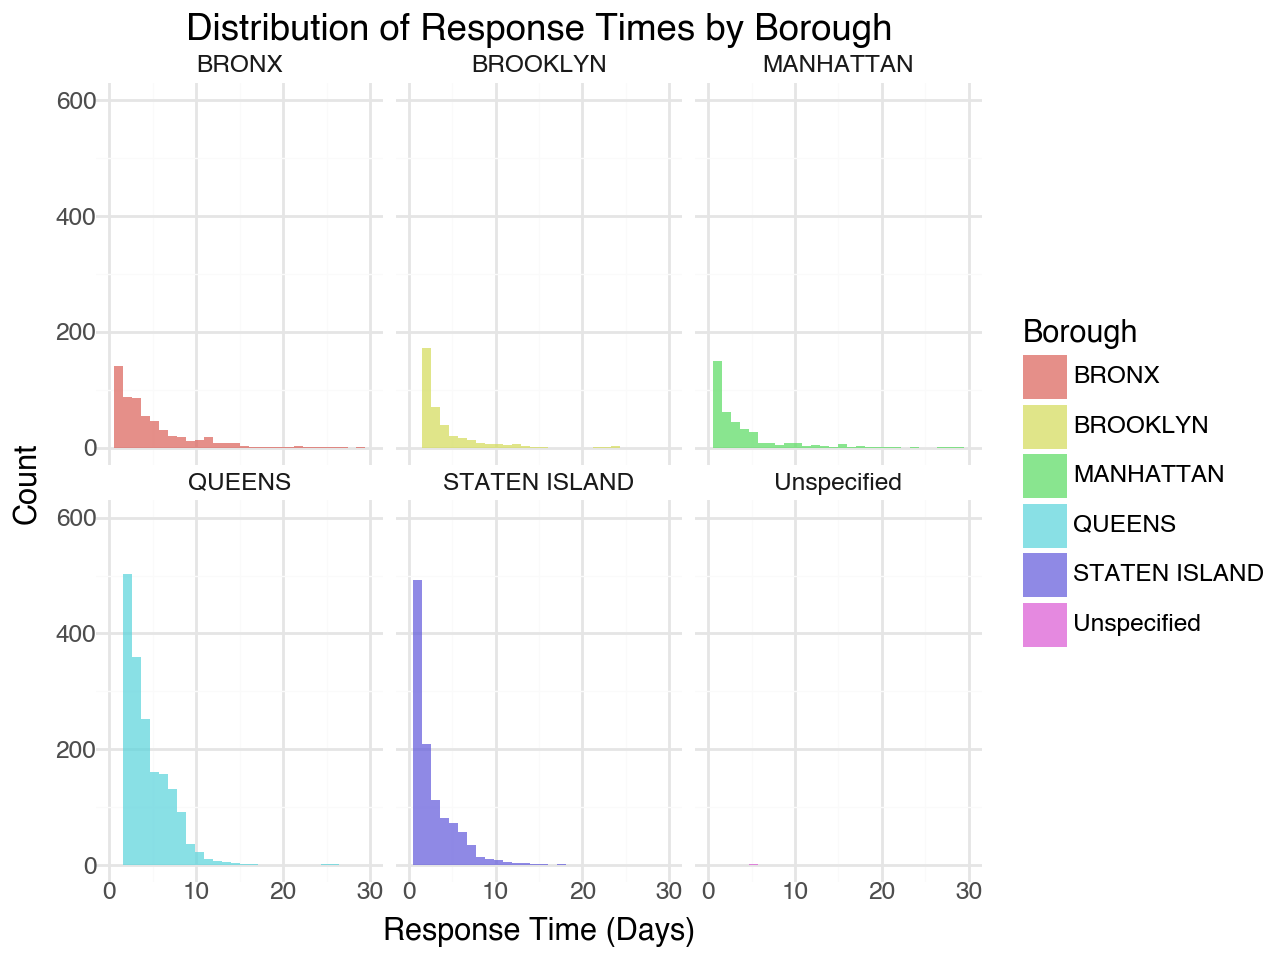

In [23]:
from plotnine import ggplot, aes, geom_histogram, facet_wrap, theme_minimal, labs, scale_x_continuous, scale_y_continuous

# Create histogram plot using plotnine with x-axis limited to 0-50 days and y-axis limited to 0-700
histogram_plot = (
    ggplot(df.dropna(subset=['response_time', 'borough']), aes(x='response_time', fill='borough')) +
    geom_histogram(bins=30, alpha=0.7) +  # Adjust bin count as needed
    facet_wrap('~borough') +  # Separate histograms for each borough
    scale_x_continuous(limits=(0, 30)) +  # Limit x-axis to 0-50 days
    scale_y_continuous(limits=(0, 600)) +  # Limit y-axis to 0-700
    theme_minimal() +
    labs(
        title="Distribution of Response Times by Borough",
        x="Response Time (Days)",
        y="Count",
        fill="Borough"
    )
)

# Display the plot
histogram_plot

## Create a binary variable over3d to indicate that a service request took three days or longer to close

In [24]:
df['over3d'] = (df['response_time'] >= 3).astype(int)

df[['response_time', 'over3d']].head(10)

,response_time,over3d
0,0.284722,0
1,0.477778,0
2,0.304167,0
3,0.531250,0
4,1.606944,0
5,0.490278,0
6,0.558333,0
7,0.693056,0
8,0.806944,0
9,0.759028,0


In [25]:
df_over3d = df[df['over3d'] == 1]

# Show relevant columns
df_over3d[['created_date', 'closed_date', 'response_time', 'over3d']].head(10)

,created_date,closed_date,response_time,over3d
61,2024-12-28 22:44:00,2025-01-02 09:00:00,4.427778,1
93,2024-12-26 23:20:00,2024-12-30 03:35:00,3.177083,1
95,2024-12-26 19:23:00,2024-12-30 02:30:00,3.296528,1
96,2024-12-26 15:05:00,2025-01-03 10:40:00,7.815972,1
98,2024-12-26 12:41:00,2024-12-30 11:56:00,3.968750,1
100,2024-12-26 12:11:00,2024-12-30 13:30:00,4.054861,1
134,2024-12-21 15:50:00,2024-12-26 12:15:00,4.850694,1
135,2024-12-21 15:17:00,2024-12-26 13:35:00,4.929167,1
138,2024-12-21 09:38:00,2024-12-30 12:00:00,9.098611,1
141,2024-12-20 17:41:00,2024-12-24 18:20:00,4.027083,1


## Does over3d depend on the complaint descriptor, borough, or weekday (vs weekend/holiday)? State your hypotheses, justify your test, and summarize your results.

Chi-squared test is appropriate because it evaluates whether there is an association between categorical variables. In this case, it creates a frequency table evaluating whether there is an association between these over3d and complaint descriptor, borough, and weekday.

Ho: The likelihood of the service request taking over 3 days is independent of the complaint descriptor, borough, and weekday

H1: The likelihood of a service request taking 3+ days (over3d) depends on one or more of these factors

In [26]:
from scipy.stats import chi2_contingency

# Create a new variable for weekday vs. weekend/holiday
df['created_weekday'] = df['created_date'].dt.weekday  # Monday=0, Sunday=6
df['weekend_holiday'] = df['created_weekday'].apply(lambda x: 1 if x >= 5 else 0)  # 1 = Weekend, 0 = Weekday

# Function to perform chi-square test
def chi_square_test(cat_var):
    contingency_table = pd.crosstab(df[cat_var], df['over3d'])
    stat, p, dof, expected = chi2_contingency(contingency_table)
    return p

# Perform chi-square tests
p_descriptor = chi_square_test('descriptor')
p_borough = chi_square_test('borough')
p_weekend = chi_square_test('weekend_holiday')

# Display results
results = {
    "Descriptor vs. Over3d": p_descriptor,
    "Borough vs. Over3d": p_borough,
    "Weekday/Weekend vs. Over3d": p_weekend
}

for test, p_value in results.items():
    print(f"{test}: p-value = {p_value:.5f} - Significant? {'Yes' if p_value < 0.05 else 'No'}")


Descriptor vs. Over3d: p-value = 0.00000 - Significant? Yes
Borough vs. Over3d: p-value = 0.00000 - Significant? Yes
Weekday/Weekend vs. Over3d: p-value = 0.00001 - Significant? Yes


Since all p-values are less than 0.05, we reject the null hypothesis and conclude that all three factors significantly impact service request response times

* Complaint Descriptor: SF and CB have significantly different response times.
* Borough: The borough where the complaint was reported affects how long it takes to resolve.
* Weekday vs. Weekend: Requests made on weekends or holidays are more likely to take over 3 days compared to weekdays.


# Modeling the occurrence of overly long response time

## Create a data set which contains the outcome variable over3d and variables that might be useful in predicting it. Consider including time-of-day effects (e.g., rush hour vs. late-night), seasonal trends, and neighborhood-level demographics. Zip code level information could be useful too, such as the zip code area and the ACS 2023 variables (data/nyc_zip_areas.feather and data/acs2023.feather).

In [27]:
# Load rainfall, acs, and zip data
rainfall_df = pd.read_csv('rainfall_CP.csv')
acs_df = pd.read_feather('acs2023.feather')
zip_df = pd.read_feather('nyc_zip_areas.feather')

# Standardize column names
acs_df.columns = acs_df.columns.str.lower().str.replace(' ', '_')
zip_df.columns = zip_df.columns.str.lower().str.replace(' ', '_')

# Rename the columns to standardized names
rainfall_df = rainfall_df.rename(columns={'date(M/D/Y)': 'date', 'time(H:M)': 'time', 'Value': 'rainfall'})

# Convert 'date' to datetime
rainfall_df['date'] = pd.to_datetime(rainfall_df['date'])

df.columns.tolist()

['unique_key',
 'created_date',
 'closed_date',
 'agency',
 'complaint_type',
 'descriptor',
 'location_type',
 'incident_zip',
 'incident_address',
 'cross_street_1',
 'cross_street_2',
 'intersection_street_1',
 'intersection_street_2',
 'address_type',
 'city',
 'landmark',
 'facility_type',
 'status',
 'due_date',
 'resolution_description',
 'resolution_action_updated_date',
 'community_board',
 'bbl',
 'borough',
 'x_coordinate_(state_plane)',
 'y_coordinate_(state_plane)',
 'open_data_channel_type',
 'park_facility_name',
 'vehicle_type',
 'taxi_company_borough',
 'taxi_pick_up_location',
 'bridge_highway_name',
 'bridge_highway_direction',
 'road_ramp',
 'bridge_highway_segment',
 'latitude',
 'longitude',
 'response_time',
 'over3d',
 'created_weekday',
 'weekend_holiday']

In [28]:
# Rename 'incident_zip' to 'zip_code' in df to match the other datasets
df = df.rename(columns={'incident_zip': 'zip_code'})

# Rename 'modzcta' to 'zip_code' in zip_df to match the other datasets
zip_df = zip_df.rename(columns={'modzcta': 'zip_code'})

# Convert ZIP codes to strings to avoid merging issues
df['zip_code'] = df['zip_code'].astype(str)
acs_df['zip_code'] = acs_df['zip_code'].astype(str)
zip_df['zip_code'] = zip_df['zip_code'].astype(str)

# Ensure proper zip_code format for merge
df['zip_code'] = df['zip_code'].astype(float).astype(int).astype(str).str.zfill(5)
acs_df['zip_code'] = acs_df['zip_code'].astype(str).str.zfill(5)
zip_df['zip_code'] = zip_df['zip_code'].astype(str).str.zfill(5)


# Rename conflicting columns in rainfall_df BEFORE merging
rainfall_df = rainfall_df.rename(columns={'time': 'rainfall_time', 'date': 'rainfall_date', 'rainfall': 'rainfall_amount'})

# Merge df with rainfall_df, using 'created_date' and 'rainfall_date' as keys
df = df.merge(rainfall_df, left_on='created_date', right_on='rainfall_date', how='left')

# Drop redundant 'rainfall_date' column after merge
df = df.drop(columns=['rainfall_date'])

# Display first few rows to confirm merge success
df.columns.tolist()

['unique_key',
 'created_date',
 'closed_date',
 'agency',
 'complaint_type',
 'descriptor',
 'location_type',
 'zip_code',
 'incident_address',
 'cross_street_1',
 'cross_street_2',
 'intersection_street_1',
 'intersection_street_2',
 'address_type',
 'city',
 'landmark',
 'facility_type',
 'status',
 'due_date',
 'resolution_description',
 'resolution_action_updated_date',
 'community_board',
 'bbl',
 'borough',
 'x_coordinate_(state_plane)',
 'y_coordinate_(state_plane)',
 'open_data_channel_type',
 'park_facility_name',
 'vehicle_type',
 'taxi_company_borough',
 'taxi_pick_up_location',
 'bridge_highway_name',
 'bridge_highway_direction',
 'road_ramp',
 'bridge_highway_segment',
 'latitude',
 'longitude',
 'response_time',
 'over3d',
 'created_weekday',
 'weekend_holiday',
 'rainfall_time',
 'rainfall_amount']

In [29]:
# Merge with ACS demographic data and zip code areas
df = df.merge(acs_df, on='zip_code', how='left')
df = df.merge(zip_df, on='zip_code', how='left')

In [30]:
df['hour'] = df['created_date'].dt.hour

df['month'] = df['created_date'].dt.month

# Define rush hour (7-9 AM, 4-7 PM)
df['rush_hour'] = ((df['hour'].between(7, 9)) | (df['hour'].between(16, 19))).astype(int)

In [31]:
# Select relevant predictors
predictor_columns = [
    'hour', 'month', 'rush_hour', 'rainfall_amount',  
    'median_household_income', 'total_population', 'land_area_sq_miles', 
    'created_weekday', 'weekend_holiday', 'white_population',
    'asian_population', 'black_population'
]  

# Create the final modeling dataset
model_data = df[predictor_columns + ['over3d']]

model_data.head()

,hour,month,rush_hour,rainfall_amount,median_household_income,total_population,land_area_sq_miles,created_weekday,weekend_holiday,white_population,asian_population,black_population,over3d
0,23,12,0,NaN,71728.0,68182.0,17.971730,1,0,2687.0,2039.0,54552.0,0
1,23,12,0,NaN,51194.0,92283.0,2.576065,1,0,57607.0,20305.0,1444.0,0
2,23,12,0,NaN,102343.0,29544.0,3.113810,1,0,13140.0,11948.0,1154.0,0
3,22,12,0,NaN,51194.0,92283.0,2.576065,1,0,57607.0,20305.0,1444.0,0
4,22,12,0,NaN,84764.0,42211.0,6.984561,1,0,27671.0,8503.0,2004.0,0


## Randomly select 20% of the complaints as testing data with seeds 1234. Build a logistic model to predict over3d for the complaints with the training data. If you have tuning parameters, justify how they were selected.

### Fill Missing Values

In [32]:
# Count NaN values in predictor columns
nan_counts = df[predictor_columns].isna().sum()

# Filter only columns that contain NaN values
nan_columns = nan_counts[nan_counts > 0]

# Display columns with NaN values and their count
print("Predictor columns with NaN values:")
print(nan_columns)

Predictor columns with NaN values:
rainfall_amount            9274
median_household_income      29
total_population             29
land_area_sq_miles           43
white_population             29
asian_population             29
black_population             29
dtype: int64


In [33]:
# Fill NaN values in rainfall_amount with 0
df['rainfall_amount'] = df['rainfall_amount'].fillna(0)
df[predictor_columns].isna().sum()

hour                        0
month                       0
rush_hour                   0
rainfall_amount             0
median_household_income    29
total_population           29
land_area_sq_miles         43
created_weekday             0
weekend_holiday             0
white_population           29
asian_population           29
black_population           29
dtype: int64

In [34]:
from sklearn.impute import KNNImputer

# Define only the columns that need imputation
columns_to_impute = ['median_household_income', 'total_population', 
                     'land_area_sq_miles', 'white_population', 'asian_population', 
                     'black_population'
                    ]

# Initialize KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation only to the selected columns
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Verify if any NaN values remain in the selected columns
print("Remaining NaN values after imputation:", df[columns_to_impute].isna().sum().sum())  # Should print 0

Remaining NaN values after imputation: 0


In [35]:
df[predictor_columns].isna().sum()

hour                       0
month                      0
rush_hour                  0
rainfall_amount            0
median_household_income    0
total_population           0
land_area_sq_miles         0
created_weekday            0
weekend_holiday            0
white_population           0
asian_population           0
black_population           0
dtype: int64

### Fit logistic model

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Set random seed
np.random.seed(1234)

# Define target
target = 'over3d'

X = df[predictor_columns]
y = df[target]

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Initialize and train logistic regression model
log_model = LogisticRegression(max_iter=10000, random_state=1234, class_weight='balanced')
log_model.fit(X_train, y_train)

# Display model coefficients
coef_df = pd.DataFrame({'predictor_columns': predictor_columns, 'Coefficient': log_model.coef_[0]})
print(coef_df)


Training set size: 7419
Testing set size: 1855
          predictor_columns  Coefficient
0                      hour    -0.013892
1                     month     0.000090
2                 rush_hour    -0.037533
3           rainfall_amount     0.000000
4   median_household_income     0.000003
5          total_population     0.000026
6        land_area_sq_miles     0.089919
7           created_weekday     0.251246
8           weekend_holiday    -1.159726
9          white_population    -0.000065
10         asian_population    -0.000062
11         black_population    -0.000053


In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions using the trained logistic model
y_train_pred = (log_model.predict_proba(X_train)[:, 1] >= 0.5).astype(int)
y_test_pred = (log_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)

# Compute confusion matrices
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

print("Confusion Matrix - Training Data:\n", conf_matrix_train)
print("Confusion Matrix - Testing Data:\n", conf_matrix_test)

# Calculate evaluation metrics for training data
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

# Calculate evaluation metrics for testing data
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

# Display results
print(f"Training Accuracy: {accuracy_train:.3f}, Precision: {precision_train:.3f}, Recall: {recall_train:.3f}, F1-score: {f1_train:.3f}")
print(f"Testing Accuracy: {accuracy_test:.3f}, Precision: {precision_test:.3f}, Recall: {recall_test:.3f}, F1-score: {f1_test:.3f}")


Confusion Matrix - Training Data:
 [[3447 2358]
 [ 551 1063]]
Confusion Matrix - Testing Data:
 [[900 552]
 [138 265]]
Training Accuracy: 0.608, Precision: 0.311, Recall: 0.659, F1-score: 0.422
Testing Accuracy: 0.628, Precision: 0.324, Recall: 0.658, F1-score: 0.434


### LASSO

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define parameter grid for LASSO (L1 regularization)
param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1'],  # L1
    'solver': ['liblinear']
}

# Logistic Regression with balanced class weights
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced')

# Perform Grid Search with 5-fold cross-validation (scoring based on F1-score)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best model from Grid Search
best_model = grid_search.best_estimator_

# Make predictions using the optimized logistic model
y_train_pred = (best_model.predict_proba(X_train)[:, 1] >= 0.5).astype(int)
y_test_pred = (best_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)

# Compute confusion matrices
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

print("Confusion Matrix - Training Data:\n", conf_matrix_train)
print("Confusion Matrix - Testing Data:\n", conf_matrix_test)

Confusion Matrix - Training Data:
 [[3420 2385]
 [ 535 1079]]
Confusion Matrix - Testing Data:
 [[898 554]
 [134 269]]


In [39]:
# Calculate evaluation metrics for training data
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, zero_division=1)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

# Calculate evaluation metrics for testing data
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, zero_division=1)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

# Display results
print(f"Training Accuracy: {accuracy_train:.3f}, Precision: {precision_train:.3f}, Recall: {recall_train:.3f}, F1-score: {f1_train:.3f}")
print(f"Testing Accuracy: {accuracy_test:.3f}, Precision: {precision_test:.3f}, Recall: {recall_test:.3f}, F1-score: {f1_test:.3f}")

Training Accuracy: 0.606, Precision: 0.311, Recall: 0.669, F1-score: 0.425
Testing Accuracy: 0.629, Precision: 0.327, Recall: 0.667, F1-score: 0.439


### Explanation

Accuracy:

* Training: 60.6%
* Testing: 62.9%
* If the model is 60-63% accurate, that means that the model correctly estimates the wait time 6/10 times, while the other 4/10 times you may be waiting a longer or shorter period of time than expected.


Precision:

* Training: 31.1%
* Testing: 32.7%
* This is how often the model correctly pin pointed a complaint that took over 3 days to complete. Since precision is low, it means we’re sometimes falsely predicting delays that do not occur.

Recall:

* Training: 69.9%
* Testing: 66.7%
* This means that we are catching about every 2/3 late complaints. Therefore, about 1/3 of complaints are waiting longer than expected.

F1 Score: The Balance Between Precision & Recall

* Training: 42.5%
* Testing: 43.9%
* This is the balance between precision and recall - balance between calling things late and things actually being late. If F1 is too low, we are either predicting complaints taking too long or not long enough. 

## Construct the ROC curve of your fitted logistic model and obtain the AUROC for both training and testing data. Explain your results to a New Yorker.

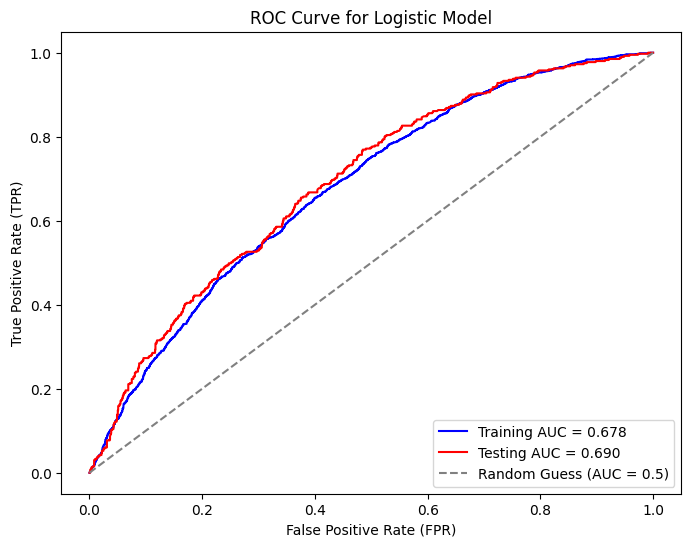

Training AUROC: 0.678
Testing AUROC: 0.690


In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get probability scores for positive class (over3d = 1)
y_train_probs = log_model.predict_proba(X_train)[:, 1]
y_test_probs = log_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for testing data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, label=f'Training AUC = {roc_auc_train:.3f}', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Testing AUC = {roc_auc_test:.3f}', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess (AUC = 0.5)")

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Logistic Model')
plt.legend(loc='lower right')
plt.show()

# Print AUROC scores
print(f"Training AUROC: {roc_auc_train:.3f}")
print(f"Testing AUROC: {roc_auc_test:.3f}")

### ROC Explanation

The AUROC (Area Under the Receiver Operating Characteristic Curve) is a score between 0 and 1 that shows how well the model can separate late complaints from on-time complaints:

1.0 (Perfect Model) → The model always correctly identifies late complaints.
0.5 (Random Guessing) → The model is no better than flipping a coin.

Therefore, this model is 70% better than a random guess at distinguishing late complaints from on-time ones.

## Identify the most important predictors of over3d. Use model coefficients or feature importance (e.g., odds ratios, standardized coefficients, or SHAP values).

In [44]:
# Get the logistic regression coefficients
coef_df = pd.DataFrame({'predictor_columns': X_train.columns, 'Coefficient': log_model.coef_[0]})

# Compute Odds Ratios (exponentiate the coefficients)
coef_df['Odds Ratio'] = np.exp(coef_df['Coefficient'])

# Sort by absolute importance (higher coefficient magnitude means stronger effect)
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Display feature importance
coef_df

,predictor_columns,Coefficient,Odds Ratio
7,created_weekday,0.251246,1.285626
6,land_area_sq_miles,0.089919,1.094086
1,month,0.000090,1.000090
5,total_population,0.000026,1.000026
4,median_household_income,0.000003,1.000003
3,rainfall_amount,0.000000,1.000000
11,black_population,-0.000053,0.999947
10,asian_population,-0.000062,0.999938
9,white_population,-0.000065,0.999935
0,hour,-0.013892,0.986205


This table shows how each predictor influences whether a complaint takes more than 3 days to complete.

Coefficient: How much the feature increases or decreases the likelihood of a delay.
Odds Ratio (>1 increases delays, <1 decreases delays).

## Summarize your results to a New Yorker who is not data science savvy in several bullet points.

* Weekday complaints take longer.
    * If you report an issue Monday-Friday, it’s more likely to be delayed than if you report it on a weekend.

* Larger areas = longer wait times.
    * If you live in a big neighborhood with lots of land, response times tend to be slower.

* Weekend & holiday complaints get fixed faster.
    * Complaints made on weekends/holidays are way less likely to be delayed.

* Rush hour doesn’t slow things down.
    * Surprisingly, complaints during rush hour are actually resolved a little faster.

* Your neighborhood’s income or racial makeup doesn’t affect response times.
    * Whether your area is wealthy or has a high population of a certain group doesn’t seem to change how long it takes.
 
Takeaways

* If you want a faster response, report your flooding complaint on a weekend or holiday.

* If you live in a large area, expect a longer wait.

# Modeling the count of SF complains by zip code